CIFAR-10-CLASSIFCATION MODEL
---
Jack Zheng

In this Notebook I will try to create a classification model for the cifar-10 dataset using tensorflow

# Contents:

#### Wrangling Data

#### Displaying image

#### Creating model

#### optimizing model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Wrangling Data

This unpickle function was provided on the website to open the file:

In [2]:
def unpickle(file): # - http://www.cs.toronto.edu/~kriz/cifar.html - this will open the file and return a dictionary 
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
dataset = unpickle("cifar-10-batches-py\data_batch_1") # loading data_batch_1 into the variable dataset
metadata = unpickle(r"cifar-10-batches-py\batches.meta") # These are the label names

Instead of importing the dataset directly, I decided to install it as a zip from online, to practice loading and wrangling the data

The website source of the dataset states:

 **data** -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels** -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [4]:
print(dataset.keys(),
metadata.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames']) dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


We can see the the relevant items in the dataset and metadata dictionary

In [5]:
labels = dataset[b'labels']
data = dataset[b'data']

In [6]:
len(data)
len(labels)

10000

As you can see, there are 10000 images + labels in our dataset. I will split the dataset in 80-20 training-testing into the following variables:

In [7]:
X_train = data[:8000]
X_test = data[8000:10000]

y_train = labels[:8000]
y_test = labels[8000:10000]

In [8]:
metadata.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [9]:
keys = metadata[b'label_names']
keys

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

# Displaying image

In [10]:
y_train[0]
# plt.imshow(X_train[0]) # This line throws a TypeError: Invalid shape (3072,) for image data. I realized, this is actually a 32 x 32 size image with RGB, however since there is nothing delimiting the rows
# So it just shows as 3072 - The images seem to have flattened, meaning I would need to "unflattern" them if I want to view them
# https://stackoverflow.com/questions/36967920/numpy-flatten-rgb-image-array 


6

In [11]:
test = X_train[0]

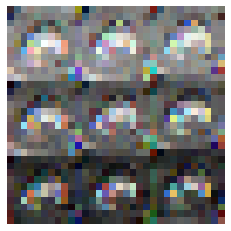

In [12]:
reshaped_image = test.reshape(32,32,3) # 32 x 32 (image size) with the 3 denoting the RGB values

plt.imshow(reshaped_image)
plt.axis('off') 
plt.show()



I'm going to have to reformat the array If I want to view the image, I will create a function that will allow me to view the image without changing the data structure of the original image

In [13]:
def show_image(index = 0, feature_data = X_train, label_data = y_train, keys = keys):
        """
        input feature, and label data, and the keys dictionary, optional param index

        displays the image + label
        """
        # The images are stored as a 3072 element vector, I need to reshape this into a tensor 
        # The image source states "The first 1024 bytes are the red channel values, the next 1024 the green,
        # and the final 1024 the blue. The values are stored in row-major order, so the first 32 bytes are the red channel values of the first row of the image."
        res = feature_data[index].reshape(3,32,32) 
        #matplotlib reads the RGB channels last in the matrix. So I'm rearranging the tensor accordingly
        res = np.transpose(res, axes=[1, 2, 0]) 

        plt.imshow(res)
        plt.title(keys[label_data[index]].decode("utf-8")) # adds the label; the decode removes the b and '' from the label for a pleasant viewing experience
        plt.axis('off') # I don't want the axis to show either
        plt.show()




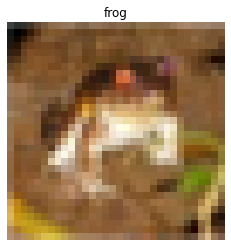

In [14]:
show_image()

# Creating model using Tensorflow

In [15]:
X_train, X_test = X_train / 255.0, X_test / 255.0
# since the values range from 1 to 256, I want them to range from 0-1, i will divide by 255 to achieve this. 
# Sources state this allows the model to perform more efficiently


In [16]:
model = tf.keras.Sequential([ # My model should have one input and one output tensor
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape = (3072,)), # input shape of 3072
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # relu is a activation function, which determines the
    # output shape of each node in the layer
    tf.keras.layers.Dense(10)])

# There is 2 layers with 128 nodes each, and a output layer with 10 nodes, each representing one of the 
# 10 possible categories    

In [17]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = 'adam', metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train,y_train,batch_size=32)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

When trying to compile my model I run into this error

    ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

I think I can fix this by converting my datasets for the y values into numpy arrays, since they were originally lists containing ints


In [28]:
y_train = np.array(y_train)
y_test = np.array(y_test)



In [ ]:
statistics_1 = model.fit(X_train,y_train,batch_size=32,epochs = 5)

Epoch 1/5
250/250 [==============================] - 1s 5ms/step - loss: 12.3168 - accuracy: 0.1011
Epoch 2/5
250/250 [==============================] - 1s 5ms/step - loss: 12.3168 - accuracy: 0.1011
Epoch 3/5
250/250 [==============================] - 1s 5ms/step - loss: 12.3168 - accuracy: 0.1011
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 12.3168 - accuracy: 0.1011
Epoch 5/5
250/250 [==============================] - 2s 6ms/step - loss: 12.3168 - accuracy: 0.1011


The loss and accuracy are not changing between epochs, There seems to be a problem

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 12.3813 - accuracy: 0.0960


there is a accuracy of 0.09 when testing against the testing set.


In [ ]:
predictions = model.predict(X_test)

63/63 [==============================] - 0s 3ms/step


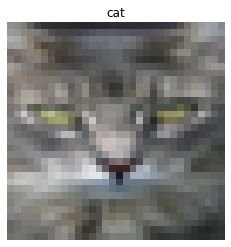

NameError: name 'predictions' is not defined

In [ ]:
image = X_test[0]
show_image(0, X_test, y_test)
keys[np.argmax(predictions[0])].decode("utf-8")



My model decided to predict this cat as a horse, it has a accuracy of 0.0990 and a high loss. My model guesses correctly 10 percent of the time, which should be expected with 10 outputs if you were to guess at random. My model doesn't work at all, it is completely broken. I believe there was something wrong with building the layers. I will try to focus on creating a working model.

## Optimization 1

---

Since data is already flattened, in the shape (3072,), I will not need to flatten the data.

I believe there was a problem with the output layer, This time I will change the activation function of the output layer, into softmax

In [ ]:
from tensorflow import keras 

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation = 'relu'), # 128 neurons
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax') # Since there are 10 output classifications
    ])

In [ ]:
model.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])


In [20]:
model.build((1,3072))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________


In [63]:
statistic_2 = model.fit(X_train,y_train, epochs = 10)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "c:\Users\maste\anaconda3\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(32,) and logits.shape=(32768, 10)


In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 3ms/step - loss: 1.8911 - accuracy: 0.4070


This model with 30 epochs, has a accuracy of 0.7412, however when testing, the accuracy drops to 0.401
I think this means overfitting, My model seems to work properly this time, the accuracy of 40, means my model is actually working as intended, however it is not very reliable. I need to try and optimize it 

## Optimization 2

---

In this attempt, I will wrangle the data before feeding it to the model, using a modified show_image function, and include a extra flatten layer in my model, to see if this makes any difference.

In [21]:
X_train = data[:8000]
X_test = data[8000:10000]

y_train = labels[:8000]
y_test = labels[8000:10000]

In [22]:
def convert_dataset(dataset):
        """
        input dataset
        converts the vector tensors inside the dataset into a eligible format

        returns a dataset with converted images.
        """
        res = [] 
        for i in range(len(dataset)):
                res.append(np.transpose(dataset[i].reshape(3,32,32), axes = [1,2,0]))
                
        return np.array(res)/255.0 # I had to convert the list into numpy array and divide all the elements by 255.0

    


In [23]:
X_train = convert_dataset(X_train)
X_test = convert_dataset(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


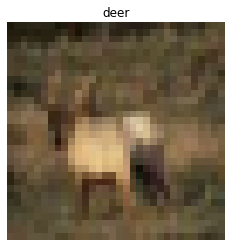

In [24]:
plt.imshow(X_train[3])
plt.title(keys[y_train[3]].decode("utf-8"))
plt.axis('off') 
plt.show()

My images seem to be legible

#### Creating the model

This model will be similar to the second attempt, with a extra flatten layer

In [25]:
import tensorflow as tf
from tensorflow import keras


In [26]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax') # Since there are 10 output classifications
    ])

In [27]:
model.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [98]:
statistic_3 = model.fit(X_train,y_train,batch_size= 32,epochs = 30)

Epoch 1/30
250/250 [==============================] - 2s 6ms/step - loss: 2.0601 - accuracy: 0.2365
Epoch 2/30
250/250 [==============================] - 2s 6ms/step - loss: 1.8824 - accuracy: 0.3165
Epoch 3/30
250/250 [==============================] - 2s 6ms/step - loss: 1.7997 - accuracy: 0.3476
Epoch 4/30
250/250 [==============================] - 2s 7ms/step - loss: 1.7465 - accuracy: 0.3677
Epoch 5/30
250/250 [==============================] - 2s 6ms/step - loss: 1.7014 - accuracy: 0.3832
Epoch 6/30
250/250 [==============================] - 2s 6ms/step - loss: 1.6538 - accuracy: 0.4066
Epoch 7/30
250/250 [==============================] - 2s 6ms/step - loss: 1.6269 - accuracy: 0.4180
Epoch 8/30
250/250 [==============================] - 2s 7ms/step - loss: 1.6032 - accuracy: 0.4209
Epoch 9/30
250/250 [==============================] - 2s 6ms/step - loss: 1.5732 - accuracy: 0.4339
Epoch 10/30
250/250 [==============================] - 2s 6ms/step - loss: 1.5445 - accuracy: 0.4491

In [28]:
test_loss, test_acc = model.evaluate(X_test,y_test)

63/63 [==============================] - 1s 3ms/step - loss: 2.4139 - accuracy: 0.1080


Feeding in (3,32,32) tensors as opposed to (3072,) seems to have no effect on the performance of the model. when evaluating the model. It still has the exact same accuracy of 0.407, and is overfitted with a accuracy of 0.7951

A accuracy of 40% isn't too bad, it suggests i'm on the right track, as it shows my model isn't just guessing randomly with a accuracy of 10%. So my model is working, just not optimally.

## Optimization 3
---

I decided to improve the model itself. Instead of using 2 dense layers, I decided to build a model with multiple layers, and varying types to improve my accuracy

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential


In [30]:
X_train = data[:8000]
X_test = data[8000:10000]

y_train = labels[:8000]
y_test = labels[8000:10000]

X_train = convert_dataset(X_train)
X_test = convert_dataset(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)



In [31]:
X_train[0].shape

(32, 32, 3)

In [32]:
def create_model():
    model = Sequential() # creating sequential model

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape)) # input layer, 
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape)) # input layer, 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation = 'softmax'))
    return model


In [33]:
model = create_model()
model.compile(optimizer='adam',loss= "SparseCategoricalCrossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [25]:

statistic_4 = model.fit(X_train, y_train,batch_size = 32, epochs=50, validation_data=(X_test, y_test),shuffle = True)


Epoch 1/50
250/250 [==============================] - 25s 97ms/step - loss: 2.1467 - accuracy: 0.1630 - val_loss: 1.9638 - val_accuracy: 0.2140
Epoch 2/50
250/250 [==============================] - 24s 97ms/step - loss: 1.8804 - accuracy: 0.2634 - val_loss: 1.8947 - val_accuracy: 0.2795
Epoch 3/50
250/250 [==============================] - 24s 96ms/step - loss: 1.7223 - accuracy: 0.3406 - val_loss: 1.6327 - val_accuracy: 0.3815
Epoch 4/50
250/250 [==============================] - 24s 96ms/step - loss: 1.5668 - accuracy: 0.4109 - val_loss: 1.4775 - val_accuracy: 0.4565
Epoch 5/50
250/250 [==============================] - 24s 96ms/step - loss: 1.4423 - accuracy: 0.4633 - val_loss: 1.4869 - val_accuracy: 0.4435
Epoch 6/50
250/250 [==============================] - 24s 98ms/step - loss: 1.3328 - accuracy: 0.5086 - val_loss: 1.4273 - val_accuracy: 0.4700
Epoch 7/50
250/250 [==============================] - 24s 97ms/step - loss: 1.2101 - accuracy: 0.5606 - val_loss: 1.4016 - val_accuracy:

In [34]:
plt.plot(statistic_4.history['accuracy'], label='accuracy')
plt.plot(statistic_4.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

NameError: name 'statistic_4' is not defined

Here in these on around epoch 8, validation loss started increasing, the accuracy of the model on the training data reached 0.98 on the last epoch, while validation_accuracy hovered around 0.53 since epoch 8 

## Optimization 4

---

I will utilize all the provided data batches to try and optimize the validation accuracy

In [52]:
batch1 = unpickle("cifar-10-batches-py\data_batch_1") # loading data_batch_1 into the variable dataset
batch2 = unpickle("cifar-10-batches-py\data_batch_2") # loading data_batch_1 into the variable dataset
batch3 = unpickle("cifar-10-batches-py\data_batch_3") # loading data_batch_1 into the variable dataset
batch4 = unpickle("cifar-10-batches-py\data_batch_4") # loading data_batch_1 into the variable dataset
batch5 = unpickle("cifar-10-batches-py\data_batch_5") # loading data_batch_1 into the variable dataset



I will concatenate all the datasets

In [53]:
labels = batch1[b'labels'] + batch2[b'labels'] + batch3[b'labels'] + batch4[b'labels'] + batch5[b'labels']

In [54]:
data = None
data = np.concatenate([batch1[b'data'],
                       batch2[b'data'],
                       batch3[b'data'],
                       batch4[b'data'],
                       batch5[b'data'],
 ])

In [55]:
model = create_model()
model.compile(optimizer='adam',loss= "SparseCategoricalCrossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [56]:
X_train = convert_dataset(data[:40000])
X_test = convert_dataset(data[40000:50000])

y_train = np.array(labels[:40000])
y_test = np.array(labels[40000:50000])





In [57]:
statistic_5 = model.fit(X_train, y_train,batch_size = 32, epochs=8, validation_data=(X_test, y_test),shuffle = True)


Epoch 1/8
1250/1250 [==============================] - 136s 107ms/step - loss: 1.7186 - accuracy: 0.3540 - val_loss: 1.3694 - val_accuracy: 0.5045
Epoch 2/8
1250/1250 [==============================] - 126s 101ms/step - loss: 1.2325 - accuracy: 0.5583 - val_loss: 1.0975 - val_accuracy: 0.6093
Epoch 3/8
1250/1250 [==============================] - 141s 112ms/step - loss: 0.9999 - accuracy: 0.6462 - val_loss: 1.0169 - val_accuracy: 0.6408
Epoch 4/8
1250/1250 [==============================] - 131s 105ms/step - loss: 0.8488 - accuracy: 0.7036 - val_loss: 0.9426 - val_accuracy: 0.6758
Epoch 5/8
1250/1250 [==============================] - 141s 113ms/step - loss: 0.7315 - accuracy: 0.7471 - val_loss: 0.8589 - val_accuracy: 0.7076
Epoch 6/8
1250/1250 [==============================] - 135s 108ms/step - loss: 0.6214 - accuracy: 0.7822 - val_loss: 0.8646 - val_accuracy: 0.7065
Epoch 7/8
1250/1250 [==============================] - 136s 109ms/step - loss: 0.5158 - accuracy: 0.8204 - val_loss: 0

313/313 - 7s - loss: 0.9820 - accuracy: 0.7148 - 7s/epoch - 23ms/step


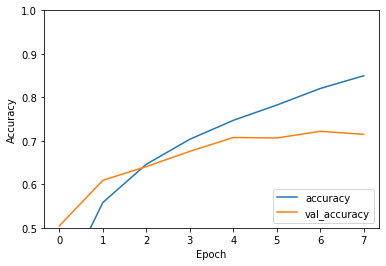

In [58]:
plt.plot(statistic_5.history['accuracy'], label='accuracy')
plt.plot(statistic_5.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

313/313 - 7s - loss: 0.9820 - accuracy: 0.7148 - 7s/epoch - 21ms/step


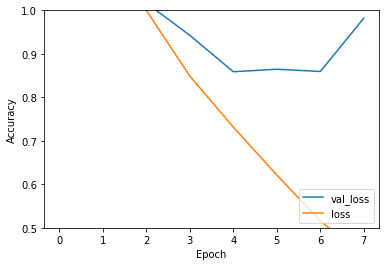

In [59]:
plt.plot(statistic_5.history['val_loss'], label = 'val_loss')
plt.plot(statistic_5.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)